In [2]:
import pandas as pd
import os
from tqdm import tqdm
import pydicom
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_excel('/data_vault/hexai02/CarpalTunnel/AI Project Data Clean 10-8.xlsx')

In [4]:
df.head(100)

,Number,WristImage Segmentation for AI Analysis,Arm (L/R),Sex,Race,Ethnicity,Age,Clinical Signs of CTS,CTS-6 Score,Measurement at Wrist
0,21,Yes,R,M,White,Non-Hispanic,43.0,Y,12.5,12.16
1,22,Yes,R,M,White,Unreported/Chose not to disclose,74.0,Y,16.5,20.10
2,23,Yes,L,M,White,Unreported/Chose not to disclose,74.0,Y,11.5,13.83
3,24,Yes,R,F,Black,Non-Hispanic,63.0,Y,21.0,16.55
4,25,Yes,R,M,White,Non-Hispanic,49.0,Y,9.0,19.21
...,...,...,...,...,...,...,...,...,...,...
95,163,Yes,R,F,White,Non-Hispanic,74.0,?,NaN,12.78
96,164,Yes,R,F,Black,Non-Hispanic,67.0,N,3.5,7.57
97,165,yes,R,F,White,Non-Hispanic,65.0,N,0.0,16.10
98,166,Yes,L,F,White,Non-Hispanic,51.0,Y,16.5,9.95


In [5]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', 'Yes', '?'], dtype=object)

In [6]:
df['Clinical Signs of CTS'] = df['Clinical Signs of CTS'].replace('Yes', 'Y')

In [7]:
df['Clinical Signs of CTS'].unique()

array(['Y', 'N', '?'], dtype=object)

In [8]:
count_question_mark = (df['Clinical Signs of CTS'] == '?').sum()
print(count_question_mark)

1


In [9]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [10]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [11]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [12]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [13]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [14]:
def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

# unet_model, _, _, _ = load_model(unet_model, optimizer=None, scheduler=None, path=f'unet_runs/epoch_40.pth')
checkpoint = torch.load('unet_runs/epoch_40.pth', map_location="cuda")
unet_model.load_state_dict(checkpoint, strict=True)
unet_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
sum(p.sum().item() for p in unet_model.parameters())

-12171.1942758339

  0%|                              | 0/87 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 7.7ms
Speed: 9.6ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)


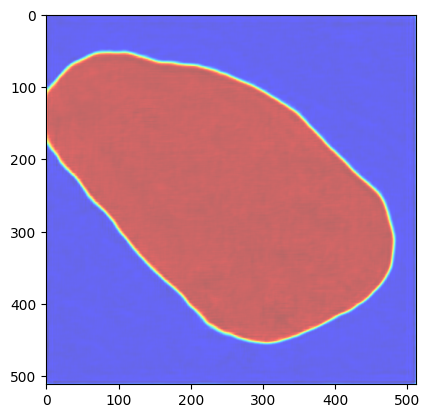

  0%|                              | 0/87 [00:00<?, ?it/s]


In [29]:
train_images = []
train_labels = []
val_images = []
val_labels = []


image_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),  # ✅ Resize first
    T.Normalize(mean=[0.5], std=[0.5]),  # ✅ Normalize after
])

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        entry_name = jpg_name.split('.')[0]
        img_filename = entry_name + '.dcm'
        
        # Load DICOM image
        img = load_dicom(os.path.join(dicom_dir, img_filename))

        # Get bounding box from YOLO
        result = model(img, save=False)
        box = result[0].boxes
        
        if len(box.xyxy.tolist()) == 0:
            continue  # Skip if no bounding box found

        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_slice = img[y1:y2, x1:x2, 0]  # Crop the region

        # Convert image slice to a PyTorch tensor
        img_tensor = torch.from_numpy(img_slice).float()  # Convert to float

        # Scale to [0,1] (Ensure correct normalization range)
        img_tensor = img_tensor / 255.0  

        # Ensure correct shape (C, H, W) before transformations
        if img_tensor.dim() == 2:
            img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Convert (H, W) → (1, H, W)

        # Apply transformations
        img_tensor = image_transform(img_tensor)  # Resize and Normalize
        
        # Move tensor to device (GPU/CPU)
        img_tensor = img_tensor.to(device)

        # Run inference
        with torch.no_grad():
            mask_gpu = unet_model(img_tensor)  # Get predicted mask
        
        # Bring back tensors to CPU and convert to NumPy
        img_resized = img_tensor.squeeze().cpu().detach().numpy()  # Resized input image
        mask = mask_gpu.squeeze().cpu().detach().numpy()  # Predicted mask

        # Stack into a 2-channel image (Image + Mask)
        img_2channel = np.stack((img_resized, mask), axis=2)

        # Display the result
        plt.imshow(img_2channel[:, :, 1], cmap="jet", alpha=0.6)
        plt.show()

        break  # Run only once to check

fill_arr(image_train_dir, train_images, train_labels)